In [55]:
import numpy as np
import scipy as sp
import sympy
import math
import matplotlib.pyplot as plt
from heart import heart
from valve_p import ValveinP
from three_windkessel import PressureSystem

In [56]:
T=1
lv=heart(0.269*T,0.452*T, # tau1,2 (s)
         1.32,27.4, # m1,2
         3,0.08, # Emax,min (mmHg/mL)
         4*10**(-9),10,T)# Ks (10**(-9) s/mL), V0 (mL), T (s)

la=heart(0.110*T,0.180*T, #tau1,2
         1.32,13.1, # m1,2
         0.17,0.08, #Emax,min(mmHg/mL)
         10*10**(-9),3,T) # Ks (10**(-9) s/mL), V0 (mL), T (s)

av=ValveinP(1.06,2,5, # density, eff_length(cm), Aann(cm2)
            0.012,0.012, # Kvo,Kvc
            0) #poc

mv=ValveinP(1.06,1,7.7, # density, eff_length(cm), Aann(cm2)
            0.03,0.04, # Kvo,Kvc
            0) #poc

cap_s=PressureSystem(15, 1e-3, 1)#C,Za,R

rv=heart(0.269*T,0.452*T, # tau1, 2
         1.32,27.4, # m1,2
         0.6,0.04, #Emax, min
         20*10**(-9),55,T) # Ks, V0 ,T

ra=heart(0.110*T,0.180*T, # tau1, 2
         1.32,13.1, # m1,2
         0.15,0.04, # Emax,min
         10*10**(-9), 17, T) # Ks, V0, T

tv=ValveinP(1.06,2,8, # density, eff_length, Aann(cm2)
            0.03,0.04, # Kvo,Kvc
            0) #poc (mmHg)

pv=ValveinP(1.06,1,4, # density, eff_length, Aann(cm2)
            0.02,0.02, # Kvo,Kvc
            0) #poc

cap_p=PressureSystem(60, 1, 3)#C,Za,R

In [57]:
t_end=50
t = [0,t_end]
t_span=np.arange(0,t_end,0.05)
aeff_av_values = []
et_lv = []
p_lv_values=[]
time=[]

In [58]:
def dydt(t,y):
    v_lv = y[0]
    v_la = y[1]
    q_av = y[2]
    q_mv = y[3]
    xi_av = y[4]
    xi_mv = y[5]
    #pressure of capillaries in systemic circulation
    pa = y[6]
    v_rv = y[7]
    v_ra = y[8]
    q_tv = y[9]
    q_pv = y[10]
    xi_tv = y[11]
    xi_pv = y[12]
    #pressure of capillaries in pulmonary circulation
    pb = y[13]
    
    #calculate parameters
    #systemic
    p_la = la.p(v_la,t,q_mv,0.85*la.T)
    p_lv = lv.p(v_lv,t,q_av)
    #p_aa: pressure at the coupling point of av and capillaries
    p_aa = cap_s.pi(q_av,pa)
    #pulmonary
    p_ra = ra.p(v_ra,t,q_tv,0.85*ra.T)
    p_rv = rv.p(v_rv,t,q_pv)
    #q_cap2: flow out the capillaries of pulmonary circulation
    q_cap2 = cap_p.qout(pb,p_la)
    #p_pa: pressure at the coupling point of pv and capillaries
    p_pa = cap_p.pi(q_tv,pb)
    #q_cap1: flow out the capillaries of systemic circulation
    q_cap1 = cap_s.qout(pa,p_ra)
    
    #derivative
    #la
    dv_la = la.dv(t,v_la,q_cap2,q_mv)
    dxi_mv = mv.dxi(t,xi_mv,p_la,p_lv)
    dq_mv = mv.dq(t,q_mv,xi_mv,p_la,p_lv)
    #lv
    dv_lv = lv.dv(t,v_lv,q_mv,q_av)
    dxi_av = av.dxi(t,xi_av,p_lv,p_aa)
    dq_av = av.dq(t,q_av,xi_av,p_lv,p_aa)
    #cap sys
    dpa = cap_s.dp(t,pa,q_av,p_ra)
    #ra
    dv_ra = ra.dv(t,v_ra,q_cap1,q_tv)
    dxi_tv = tv.dxi(t,xi_tv,p_ra,p_rv)
    dq_tv = tv.dq(t,q_tv,xi_tv,p_ra,p_rv)
    #rv
    dv_rv = rv.dv(t,v_rv,q_tv,q_pv)
    dxi_pv = pv.dxi(t,xi_pv,p_rv,p_pa)
    dq_pv = pv.dq(t,q_pv,xi_pv,p_rv,p_pa)
    #cap pul
    dpb = cap_p.dp(t,pb,q_pv,p_la)
    
    #derivative vector
    dy = np.array([dv_lv, dv_la, 
                   dq_av, dq_mv, 
                   dxi_av, dxi_mv, 
                   dpa, 
                   dv_rv, dv_ra, 
                   dq_tv, dq_pv, 
                   dxi_tv, dxi_pv, 
                   dpb])
    return dy

#initial condition
y_initial = np.array([135, 27, #lv, la
                      150, 10, #qav, qmv
                      0.01, 0.5, #xi_av, xi_mv
                      5, #pa
                      180, 40, #v_rv, v_ra 
                      150, 10, #q_tv, q_pv
                      0.01, 0.5, #xi_tv, xi_pv
                      5]) # pb

#integration
sol = sp.integrate.solve_ivp(dydt , t , y0 = y_initial , t_eval = t_span, method='LSODA')

In [59]:
v_lv = sol.y[0]
v_la = sol.y[1]
q_av = sol.y[2]
q_mv = sol.y[3]
xi_av = sol.y[4]
xi_mv = sol.y[5]
pa = sol.y[6]
v_rv = sol.y[7]
v_ra = sol.y[8]
q_tv = sol.y[9]
q_pv = sol.y[10]
xi_tv = sol.y[11]
xi_pv = sol.y[12]
pb = sol.y[13]

In [60]:
aeff_av = []
et_lv = []
B_av = []
p_lv_values = []
p_la_values = []
dp_av = []
L_av = []
dq_mv = []
dxi_mv = []
L_mv = []
B_mv = []
aeff_mv = []
dp_mv = []
dxi_av = []
et_la = []
dxi_tv = []
p_ra = []
p_rv = []
p_pa = []
dp_pv = []
p_aa = []
dxi_pv = []
dp_tv = []
for i,j in zip(sol.t,range(len(sol.t))):
    aeff_av.append(av.Aeff(i, xi_av[j]))
    et_lv.append(lv.Et(i))
    et_la.append(la.Et(i,0.85*T))
    B_av.append(av.B(i, xi_av[j]))
    L_av.append(av.L(i, xi_av[j]))
    p_lv_values.append(lv.p(v_lv[j], i, q_av[j]))
    p_la_values.append(la.p(v_la[j], i, q_mv[j], 0.65*T))
    p_aa.append(cap_s.pi(q_av[j],pa[j]))
    dp_av.append(p_lv_values[-1]-p_aa[-1])
    
    dq_mv.append(mv.dq(i,q_mv[j],xi_mv[j],p_la_values[-1],p_lv_values[-1]))#time,q,xi,pin,pout
    dxi_mv.append(mv.dxi(i,xi_mv[j],p_la_values[-1],p_lv_values[-1]))
    L_mv.append(mv.L(i, xi_mv[j]))
    B_mv.append(mv.L(i, xi_mv[j]))
    aeff_mv.append(mv.Aeff(i, xi_mv[j]))
    dp_mv.append(p_la_values[-1]-p_lv_values[-1])
    dxi_av.append(av.dxi(i,xi_av[j],p_lv_values[j], cap_s.pi(q_av[j], pa[j])))
    
    p_ra.append(ra.p(v_ra[j],i,q_tv[j], 0.65*ra.T))
    p_rv.append(rv.p(v_rv[j],i,q_pv[j]))
    dxi_tv.append(tv.dxi(i,xi_tv[j],p_ra[-1],p_rv[-1]))
    
    p_pa.append(cap_p.pi(q_pv[j],pb[j]))
    dxi_pv.append(pv.dxi(i,xi_pv[j],p_rv[-1],p_pa[-1]))
    
    dp_pv.append(p_rv[-1]-p_pa[-1])
    dp_tv.append(p_ra[-1]-p_rv[-1])

Text(0, 0.5, 'dxi_av')

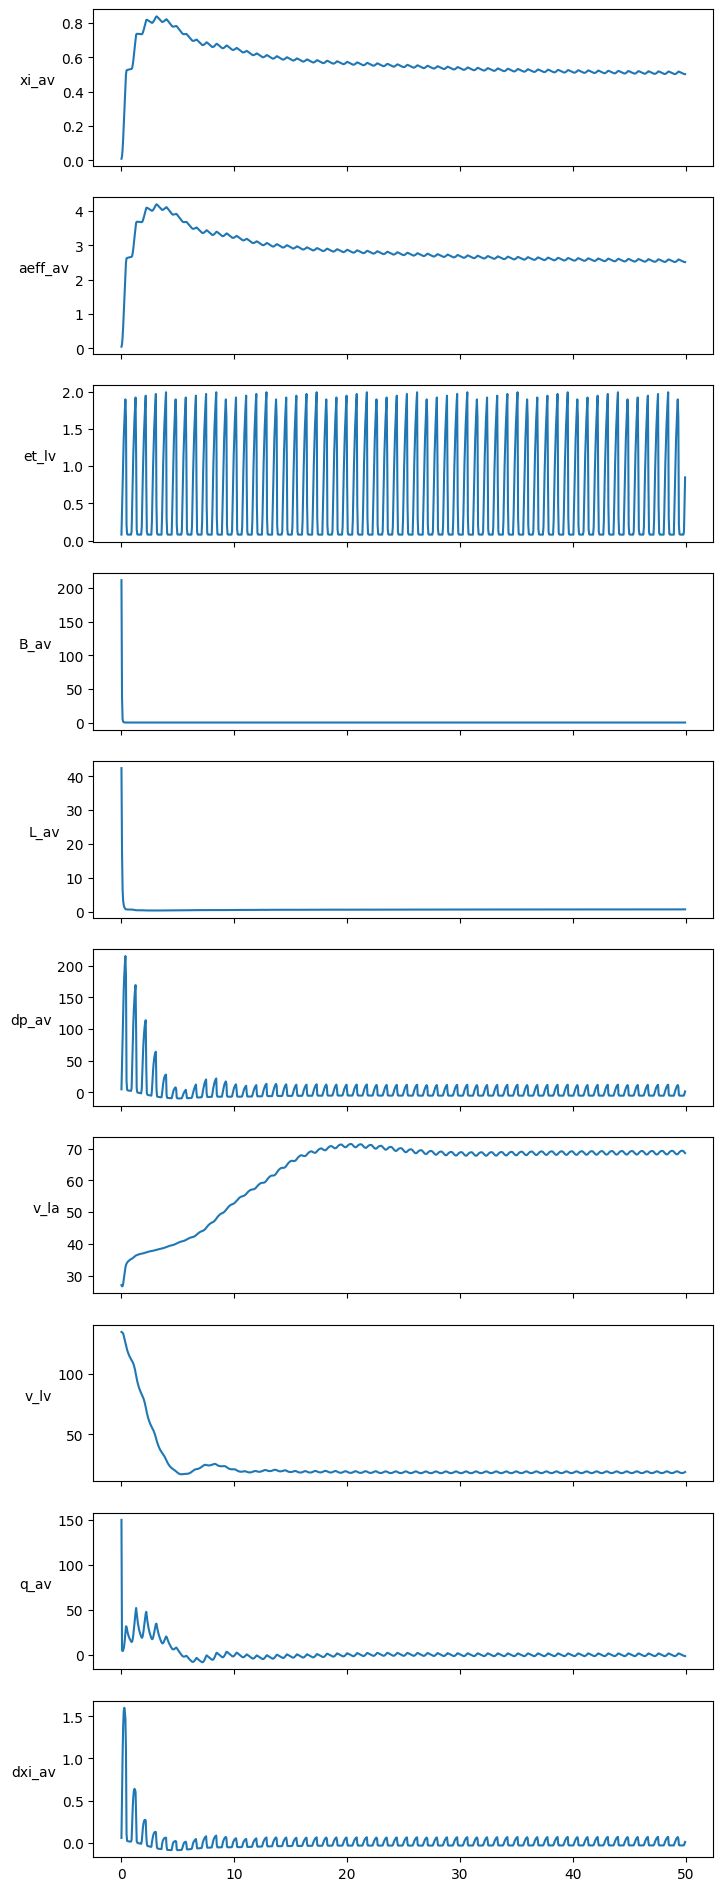

In [46]:
fig,axs = plt.subplots(10,1,sharex=True, figsize=(8, 24))
axs[0].plot(sol.t,sol.y[4])
axs[0].set_ylabel('xi_av',rotation=0, ha='right')

axs[1].plot(sol.t, aeff_av)
axs[1].set_ylabel('aeff_av',rotation=0, ha='right')

axs[2].plot(sol.t, et_lv)
axs[2].set_ylabel('et_lv',rotation=0, ha='right')

axs[3].plot(sol.t, B_av)
axs[3].set_ylabel('B_av',rotation=0, ha='right')

axs[4].plot(sol.t, L_av)
axs[4].set_ylabel('L_av',rotation=0, ha='right')


axs[5].plot(sol.t, dp_av)
axs[5].set_ylabel('dp_av',rotation=0, ha='right')

axs[6].plot(sol.t,sol.y[1])
axs[6].set_ylabel('v_la',rotation=0, ha='right')

axs[7].plot(sol.t,sol.y[0])
axs[7].set_ylabel('v_lv',rotation=0, ha='right')

axs[8].plot(sol.t,sol.y[2])
axs[8].set_ylabel('q_av',rotation=0, ha='right')

axs[9].plot(sol.t,dxi_av)
axs[9].set_ylabel('dxi_av',rotation=0, ha='right')

Text(0, 0.5, 'dp_mv')

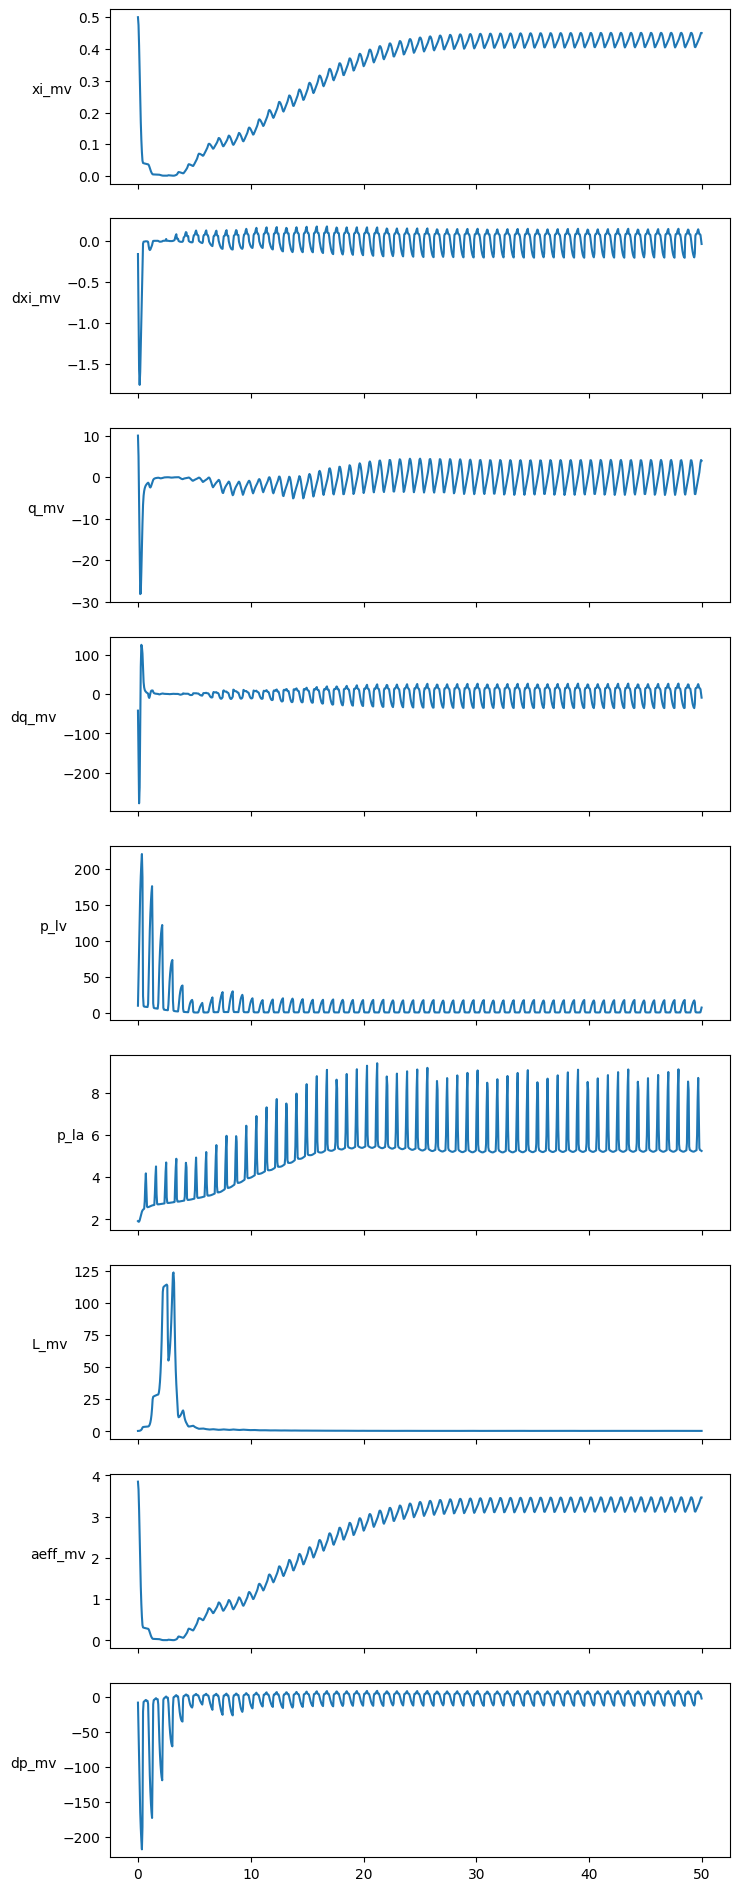

In [47]:
fig,axs = plt.subplots(9,1,sharex=True, figsize=(8, 24))
axs[0].plot(sol.t,sol.y[5])
axs[0].set_ylabel('xi_mv',rotation=0, ha='right')

axs[1].plot(sol.t, dxi_mv)
axs[1].set_ylabel('dxi_mv',rotation=0, ha='right')

axs[2].plot(sol.t,sol.y[3])
axs[2].set_ylabel('q_mv',rotation=0, ha='right')

axs[3].plot(sol.t,dq_mv)
axs[3].set_ylabel('dq_mv',rotation=0, ha='right')


axs[4].plot(sol.t, p_lv_values)
axs[4].set_ylabel('p_lv',rotation=0, ha='right')

axs[5].plot(sol.t, p_la_values)
axs[5].set_ylabel('p_la',rotation=0, ha='right')

axs[6].plot(sol.t, L_mv)
axs[6].set_ylabel('L_mv',rotation=0, ha='right')

axs[7].plot(sol.t, aeff_mv)
axs[7].set_ylabel('aeff_mv',rotation=0, ha='right')

axs[8].plot(sol.t, dp_mv)
axs[8].set_ylabel('dp_mv',rotation=0, ha='right')

Text(0, 0.5, 'xi_pv')

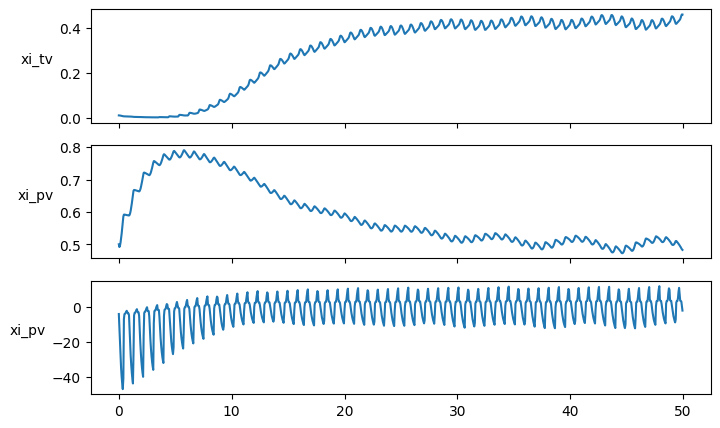

In [48]:
fig,axs = plt.subplots(3,1,sharex=True, figsize=(8, 5))
axs[0].plot(sol.t,xi_tv)
axs[0].set_ylabel('xi_tv',rotation=0, ha='right')

axs[1].plot(sol.t,xi_pv)
axs[1].set_ylabel('xi_pv',rotation=0, ha='right')

axs[2].plot(sol.t, dp_tv)
axs[2].set_ylabel('xi_pv',rotation=0, ha='right')


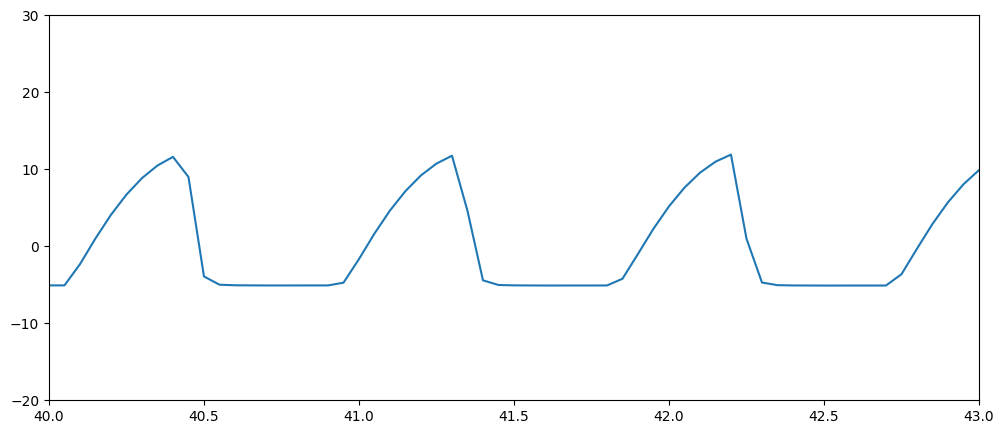

In [49]:
plt.figure(figsize=(12, 5))
#plt.plot(sol.t, p_ra)
#plt.plot(sol.t, p_rv)
plt.plot(sol.t, dp_av)
plt.xlim(40,43)
plt.ylim(-20,30)
plt.show()

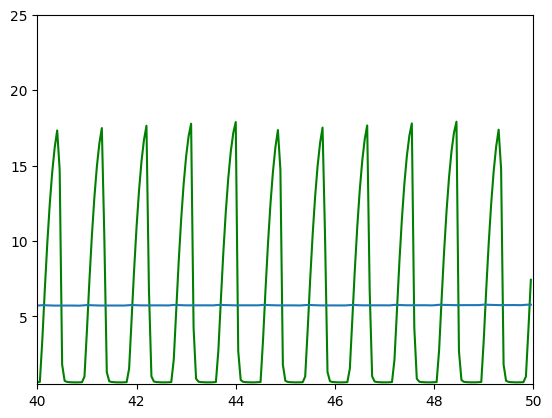

In [70]:
plt.plot(sol.t, p_lv_values,'g')
plt.plot(sol.t, p_aa)
plt.xlim(40,50)
plt.ylim(0.5,25)
plt.show()

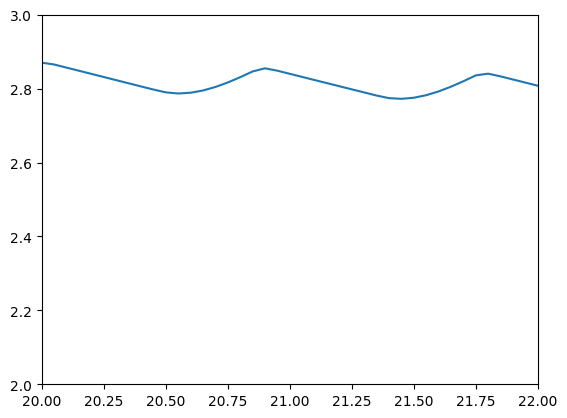

In [51]:
plt.plot(sol.t, aeff_av)
plt.xlim(20,22)
plt.ylim(2,3)
plt.show()

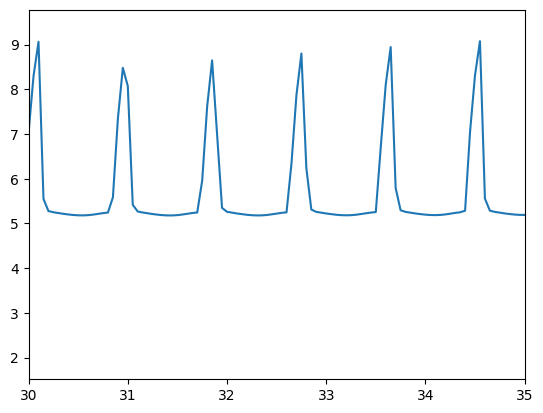

In [67]:
plt.plot(sol.t,p_la_values)
#plt.plot(sol.t, pb,'r')
plt.xlim(30,35)
#plt.ylim(0,20)
plt.show()

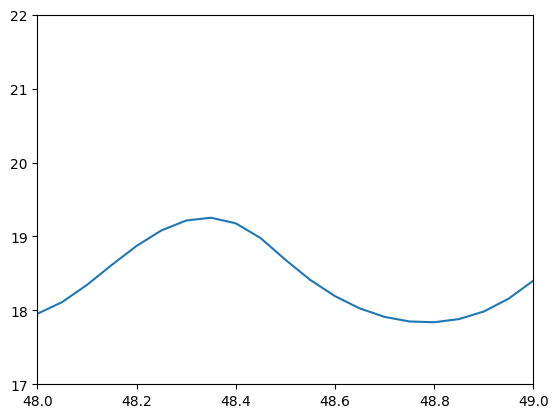

In [53]:
plt.plot(sol.t,v_lv)
plt.xlim(48,49)
plt.ylim(17,22)
plt.show()

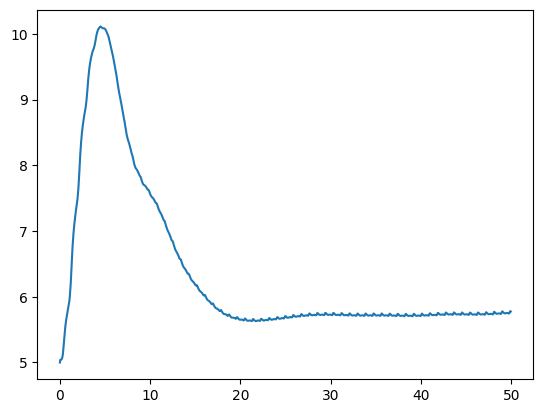

In [54]:
plt.plot(sol.t,sol.y[6])
plt.show()